# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# Data Preperation

In [2]:
def prepare_data(ds):
    ds = ds.map(lambda f, t: ((tf.cast(f, tf.float32)-122.5)/122.5, tf.one_hot(t, 10)))
    return ds.cache().shuffle(10000).batch(128).prefetch(20)

# ResNet

In [3]:
class ResidualBlock(tf.keras.Model):
    
    def __init__(self, n_filters=64, out_filters=256, mode="normal"):
        super(ResidualBlock, self).__init__()
        self.mode = mode
        
        self.conv1 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(1,1))
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        if mode == "normal":
            self.conv2a = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding="same")
            self.conv2b = tf.keras.layers.Conv2D(filters=out_filters, kernel_size=(1,1))
            
        elif mode == "strided":
            self.conv2 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding="same", strides=(2,2))
            self.pool = tf.keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2))
            
        elif mode == "constant":
            self.conv2 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), padding="same")
            
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters=out_filters, kernel_size=(1,1))
        self.bn3 = tf.keras.layers.BatchNormalization()
        
    @tf.function
    def call(self, input_tensor, training=False):        
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        
        if self.mode == "normal":
            x = self.conv2a(x)
            input_tensor = self.conv2b(input_tensor)
            
        elif self.mode == "strided":
            x = self.conv2(x)
            input_tensor = self.pool(input_tensor)
            
        elif self.mode == "constant":
            x = self.conv2(x)
            
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        
        x += input_tensor
        return tf.nn.relu(x)

In [4]:
class ResNet(tf.keras.Model):
    
    def __init__(self, n_filters, out_filters, modes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")
        self.bn = tf.keras.layers.BatchNormalization()
        
        self.blocks = [ResidualBlock(n, out, mode) for n, out, mode in zip(n_filters, out_filters, modes)]
        
        self.pool = tf.keras.layers.GlobalAvgPool2D()
        self.dense = tf.keras.layers.Dense(10, activation="softmax")
    
    @tf.function
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        
        for b in self.blocks:
            x = b(x, training=training)
            
        x = self.pool(x)
        return self.dense(x)
        

# DenseNet

In [5]:
class DenseBlock(tf.keras.Model):
    
    def __init__(self, n_filters):
        super(DenseBlock, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(n_filters * 4, kernel_size=(1,1), padding="valid", use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)
        
        self.conv2 = tf.keras.layers.Conv2D(n_filters, kernel_size=(3,3), padding="same", use_bias=False)
        self.bn2 = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)
        
        self.concat = tf.keras.layers.Concatenate(axis=3)
        
    @tf.function
    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        
        return self.concat([input_tensor, x])

In [6]:
class TransitionLayer(tf.keras.Model):
    
    def __init__(self, n_filters):
        super(TransitionLayer, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(n_filters, kernel_size=(1,1), padding="valid", use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)
        
        self.pool = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2), padding="valid")
        
    @tf.function
    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        
        x = self.pool(x)
        return x

In [7]:
class DenseNet(tf.keras.Model):
    
    def __init__(self, n_blocks, n_filters, growth_rate):
        super(DenseNet, self).__init__()
        
        self.zero_padding = tf.keras.layers.ZeroPadding2D(padding=(1, 1), data_format=None)
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")
        
        self.blocks = [[DenseBlock(n_filters) for _ in range(n)] for n in n_blocks]
        self.transitions = [TransitionLayer(n * growth_rate) for n in n_blocks[:-1]]
        
        self.bn = tf.keras.layers.BatchNormalization(epsilon=1.001e-05)
        
        self.pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(10, activation="softmax")
        
    @tf.function
    def call(self, input_tensor, training=False):
        x = self.zero_padding(input_tensor)
        x = self.max_pool(x)
        
        for i, block in enumerate(self.blocks):
            for b in block:
                x = b(x, training=training)
            if i < len(self.transitions):
                x = self.transitions[i](x, training=training)
                
        x = self.bn(x)
        x = tf.nn.relu(x)
        
        x = self.pool(x)
        return self.dense(x)

# Training Utils

In [8]:
def train_step(model, input, target, loss_function, optimizer):
# loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_data, loss_function):
# test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


def train(model, train_ds, test_ds, num_epochs, optimizer, loss_fn):
    tf.keras.backend.clear_session()
    
    # Initialize lists for later visualization.
    train_losses = []

    test_losses = []
    test_accuracies = []

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_ds, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_ds, loss_fn)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

        #training (and checking in with training)
        epoch_loss_agg = []
        for input,target in train_ds:
            train_loss = train_step(model, input, target, loss_fn, optimizer)
            epoch_loss_agg.append(train_loss)

        #track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_ds, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    return train_losses, test_losses, test_accuracies


def visualize_training(train_losses, test_losses, test_accuracies):
    # Visualize accuracy and loss for training and test data.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    line3, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1,line2, line3),("training", "test", "test accuracy"))
    plt.show()

# Training

Epoch: 0 starting with accuracy 0.0992879746835443
Epoch: 1 starting with accuracy 0.35868275316455694
Epoch: 2 starting with accuracy 0.40367879746835444
Epoch: 3 starting with accuracy 0.44214794303797467
Epoch: 4 starting with accuracy 0.44966376582278483
Epoch: 5 starting with accuracy 0.43482990506329117
Epoch: 6 starting with accuracy 0.471123417721519
Epoch: 7 starting with accuracy 0.49930775316455694
Epoch: 8 starting with accuracy 0.49376977848101267
Epoch: 9 starting with accuracy 0.5188884493670886
Epoch: 0 starting with accuracy 0.08524525316455696
Epoch: 1 starting with accuracy 0.377373417721519
Epoch: 2 starting with accuracy 0.4155458860759494
Epoch: 3 starting with accuracy 0.43156645569620256
Epoch: 4 starting with accuracy 0.44788370253164556
Epoch: 5 starting with accuracy 0.4606408227848101
Epoch: 6 starting with accuracy 0.46232199367088606
Epoch: 7 starting with accuracy 0.47132120253164556
Epoch: 8 starting with accuracy 0.4735957278481013
Epoch: 9 starting wit

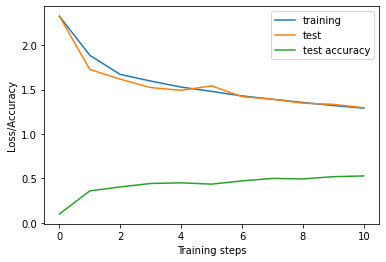

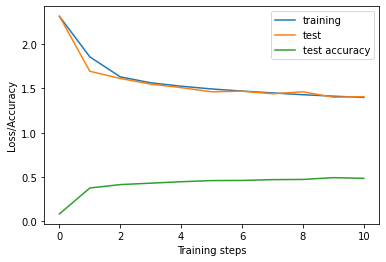

In [10]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True)
train_ds, test_ds = prepare_data(train_ds), prepare_data(test_ds)

resnet = ResNet(n_filters=[8,16,32], out_filters=[32,32,32], modes=["normal","strided","constant"])
densenet = DenseNet(n_blocks=[2,4,3], n_filters=4, growth_rate=4)

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_ds = train_ds.take(1000)
test_ds = test_ds.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
momentum = 0.5

# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate, momentum)

with tf.device('/device:gpu:0'):
    hist_resnet = train(model=resnet, train_ds=train_ds, test_ds=test_ds, num_epochs=num_epochs, optimizer=optimizer, loss_fn=cross_entropy_loss)
    hist_densnet = train(model=densenet, train_ds=train_ds, test_ds=test_ds, num_epochs=num_epochs, optimizer=optimizer, loss_fn=cross_entropy_loss)

visualize_training(*hist_resnet)
visualize_training(*hist_densnet)